In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import xpress  as xp

In [41]:
# input
N = 7
L = 1

custom_setup = True
ratio_locker_customers = 0.3
ratio_prime_door_to_door_customer = 0.4

In [42]:
# Customers’ demand and preferences
q = np.ones(N)
C = np.arange(N)

# define all the stores: eg. stores = [W, L0, L1, .... , Lx]
stores = ["W"]
for l in range(L):
    stores.append("L"+str(l))

if custom_setup:
    C_L = [0, 5]
    C_D = [1, 2, 3, 4, 6]
    S_k =[1, 2, 6]
    a_k = ["L0", "W"]
else:
    C_L = []
    C_D = []
    S_k = []
    a_k = []
    for client in C:
        if random.random()  <= ratio_locker_customers :
            # locker customer
            C_L.append(client)
            a_k.append(random.choice(stores))
        else:
            # door to door customer
            C_D.append(client)
            if random.random() >= ratio_prime_door_to_door_customer:
                S_k.append(client)


['W', 'L0', 'W', 'W', 'W', 'W', 'L0', 'L0', 'L0', 'L0', 'W', 'L0', 'W', 'L0']


[0 1 2 3 4 5 6]


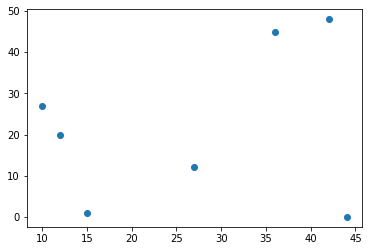

In [38]:
x = np.random.randint(0, 50, 7)
y = np.random.randint(0, 50, 7)
C = [x,y]
plt.scatter(C[0],C[1])
C = np.arange(7)
print(C)
plt.show()

In [ ]:
C = np.random.rand(7,2)
plt.scatter(C[:,0],C[:,1],color='b')
W = np.random.rand(1,2)
plt.scatter(W[:,0],W[:,1],color='g',marker='D')
L = np.random.rand(1,2)
plt.scatter(L[:,0],L[:,1],color ='y',marker='s')
print(C)

In [ ]:
C = np.array([[0.1 ,0.1], [0.2 ,0.3],[0.15 ,0.7], [0.3 ,0.7],[0.8 ,0.6],
              [0.9 ,0.5],[0.7 ,0.3]])
plt.scatter(C[:,0],C[:,1],color='b')
W = np.array([[0.6 ,0.5]])
plt.scatter(W[:,0],W[:,1],color='g',marker='D')
L = np.array([[0.3 ,0.5]])
plt.scatter(L[:,0],L[:,1],color ='y',marker='s')

In [ ]:
#calcolo la matrice delle distanze:
data = np.array([])
data = np.append(data,W)
data = np.vstack([data,L])
data = np.vstack([data,C])
buildings =['Warehouse','Locker','c1','c2','c3','c4','c5','c6','c7']
print(len(data))
df = pd.DataFrame(data, columns=['xcord', 'ycord'], index=buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()

In [ ]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
LF_delivery_cost = pi_l*matrix_distance_converted_in_numpy
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
Suplly_cost = pi_L*matrix_distance_converted_in_numpy


In [ ]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
LF_delivery_cost = pi_l*matrix_distance_converted_in_numpy
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
Suplly_cost = pi_L*matrix_distance_converted_in_numpy


In [8]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
LF_delivery_cost = pi_l*matrix_distance_converted_in_numpy
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
Suplly_cost = pi_L*matrix_distance_converted_in_numpy
